[Paper Link](https://duke.box.com/s/owa6sdzf80y0u7xjp1qxia62md6z514q)

In [19]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
from tidy3d import material_library
import scienceplots

td.config.logging_level = "ERROR"

In [9]:
# 0 Define a FreqRange object with desired wavelengths
fr = td.FreqRange.from_wvl_interval(wvl_min=1.56, wvl_max=1.58)
N = 301 # num_points
fwidth = fr.fmax - fr.fmin
freq0 = fr.freq0
lda0 = td.C_0 / fr.freq0

In [10]:
# 1 Computational Domain Size
h = 0.210  # Height of cylinder
spc = 8
sh = 3  # height of the SiO2
Lz = spc + h + spc + h

Px = Py = P = 0.750 # periodicity
sim_size = [Px, Py, Lz]

In [ ]:
# 2 Grid Resolution
dl = P / 32
horizontal_grid = td.UniformGrid(dl=dl)
vertical_grid = td.AutoGrid(min_steps_per_wvl=32)
grid_spec=td.GridSpec(
    grid_x=horizontal_grid,
    grid_y=horizontal_grid,
    grid_z=vertical_grid,
)

In [12]:
# 3 Structures and Materials
R = 0.235  # radius of the cylinder
r = 0.030  # radius of the inner hole
p = 0.080  # distance between hole to center of circle
theta = np.deg2rad(30) # angle between x-axis and p vector

Si = material_library['cSi']['Green2008']
SiO2 = material_library['SiO2']['Horiba']

outer_cylinder = td.Cylinder(
    center=[0, 0, h / 2], 
    radius=R, 
    length=h, 
    axis=2
)

inner_cylinder = td.Cylinder(
    center=[p*np.cos(theta), -p*np.sin(theta), h / 2], 
    radius=r, 
    length=h, 
    axis=2
)

cylinder = td.ClipOperation(
    operation="difference",
    geometry_a=outer_cylinder,
    geometry_b=inner_cylinder
)

atom = td.Structure(
    geometry=cylinder, 
    medium=Si,
    name="metaatom"
)

dioxide = td.Structure(
    geometry=td.Box(
        center=[0,0,-sh/2],
        size=(td.inf,td.inf, sh)
    ),
    medium=SiO2, 
    name="silicon dioxide"
)

substrate = td.Structure(
    geometry=td.Box(
        center=(0,0,-Lz/2),
        size=(td.inf,td.inf,2 * (spc - (sh - h)))
    ),
    medium=Si,
    name='substrate'
)

In [13]:
def circular_polarized_plane_wave(pol):
    # define a plane wave polarized in the x direction
    plane_wave_x = td.PlaneWave(
        source_time=td.GaussianPulse(freq0=fr.freq0, fwidth=fwidth),
        size=(td.inf, td.inf, 0),
        center=(0, 0, Lz/2 - spc + 1.5 * lda0),
        direction="-",
        pol_angle=0,
    )

    # determine the phase difference given the polarization
    if pol == "left":
        phase = -np.pi / 2
    elif pol == "right":
        phase = np.pi / 2
    else:
        raise ValueError("pol must be `left` or `right`")

    # define a plane wave polarized in the y direction with a phase difference
    plane_wave_y = td.PlaneWave(
        source_time=td.GaussianPulse(freq0=fr.freq0, fwidth=fwidth, phase=phase),
        size=(td.inf, td.inf, 0),
        center=(0, 0, Lz/2 - spc + 1.5 * lda0),
        direction="-",
        pol_angle=np.pi / 2,
    )

    return [plane_wave_x, plane_wave_y]


In [14]:
monitor = td.FluxMonitor(
    center=(0, 0, -Lz/2 + spc - (sh - h) - 0.5 * lda0),
    size=(td.inf, td.inf, 0),
    freqs=fr.freqs(N),
    name="flux_monitor"
)

# add a field monitor to see the field profile at the absorption peak frequency
monitor_field = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, 0, 2*lda0], freqs=[fr.freq0], name="field"
)


In [15]:
bandwidth = fr.fmax - fr.fmin
run_time = 50 / bandwidth # run_time for the transmittance simulation

In [16]:
bc = td.BoundarySpec(
    x=td.Boundary.periodic(), 
    y=td.Boundary.periodic(), 
    z=td.Boundary.pml()
)

In [17]:
def simulate(pol):
    structures = [substrate, dioxide, atom]
    return td.Simulation(
            size=sim_size,
            grid_spec=grid_spec,
            structures=structures,
            sources=circular_polarized_plane_wave(pol),
            monitors=[monitor, monitor_field],
            run_time=run_time,
            boundary_spec=bc
        )

In [20]:
sims = {
    "LCP": simulate("left"),
    "RCP": simulate("right"),
}

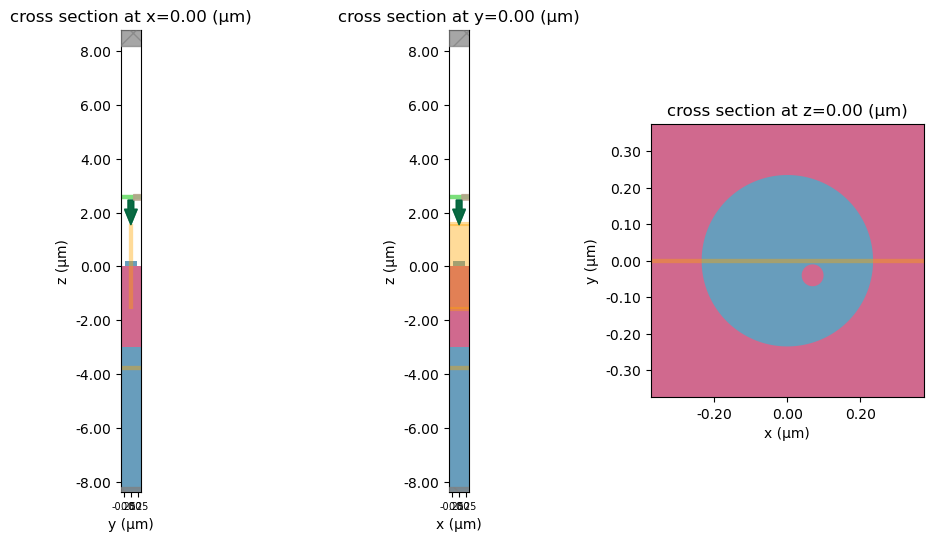

In [21]:
# Always visualize simulation before running
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.tick_params(axis='x', labelsize=7)
ax2.tick_params(axis='x', labelsize=7)
sims["LCP"].plot(x=0, ax=ax1)
# sim_actual.plot_grid(x=0, ax=ax1)
sims["LCP"].plot(y=0, ax=ax2)
# sim_actual.plot_grid(y=0, ax=ax2)
sims["LCP"].plot(z=0, ax=ax3)
# sim_actual.plot_grid(z=0, ax=ax3)
# plt.savefig(f'huygens_structure_{background[0].name}.png', dpi=300)
plt.show()

In [22]:
batch = web.Batch(simulations=sims, verbose=True)
batch_data = batch.run(path_dir="data/geom_run7")

Output()

13:32:17 EDT Started working on Batch containing 2 tasks.

13:32:19 EDT Maximum FlexCredit cost: 0.752 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

13:32:20 EDT Batch complete.

Output()

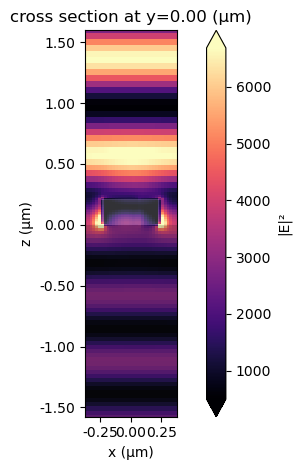

In [23]:
batch_data["LCP"].plot_field(field_monitor_name="field", field_name="E", val="abs^2")
plt.show()

In [24]:
T_lcp = batch_data["LCP"]["flux_monitor"].flux
T_rcp = batch_data["RCP"]["flux_monitor"].flux
T = T_lcp / (T_lcp + T_rcp)
# plot transmission, compare to paper results, look similar

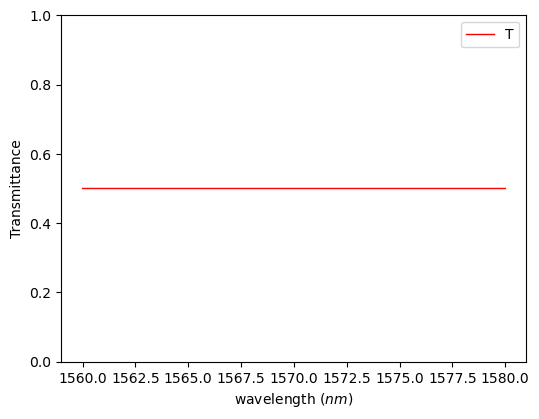

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(td.C_0 / fr.freqs(N) * 1000, T, "r", lw=1, label="T")
plt.xlabel(r"wavelength ($nm$)")
plt.ylabel("Transmittance")
plt.ylim(0, 1)
plt.legend()
plt.show()